## import libraries

In [ ]:
! unzip train.zip

Archive:  train.zip
   creating: train/
   creating: train/images/
  inflating: train/images/img_0001.jpg  
  inflating: train/images/img_0002.jpg  
  inflating: train/images/img_0003.jpg  
  inflating: train/images/img_0004.jpg  
  inflating: train/images/img_0005.jpg  
  inflating: train/images/img_0006.jpg  
  inflating: train/images/img_0007.jpg  
  inflating: train/images/img_0008.jpg  
  inflating: train/images/img_0009.jpg  
  inflating: train/images/img_0010.jpg  
  inflating: train/images/img_0011.jpg  
  inflating: train/images/img_0012.jpg  
  inflating: train/images/img_0013.jpg  
  inflating: train/images/img_0014.jpg  
  inflating: train/images/img_0015.jpg  
  inflating: train/images/img_0016.jpg  
  inflating: train/images/img_0017.jpg  
  inflating: train/images/img_0018.jpg  
  inflating: train/images/img_0019.jpg  
  inflating: train/images/img_0020.jpg  
  inflating: train/images/img_0021.jpg  
  inflating: train/images/img_0022.jpg  
  inflating: train/images/img_0

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2
import PIL.Image as Image
from PIL import ImageOps
import os
import glob as glob
import seaborn as sns

import tensorflow as tf
from keras import layers, models, callbacks
from keras.models import Sequential, Model
from keras.utils import load_img, normalize
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, AveragePooling2D
from keras.layers import Concatenate, concatenate, BatchNormalization, Dropout, Lambda, Activation
from keras.applications import ResNet50

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import random
from IPython.display import Image, display

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

from keras.models import Model
from keras import backend as K

## Prepare paths of input images and target segmentation masks for train and test set

In [ ]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CLASSES = 5
IMG_CHANNELS = 3

IMG_PATH = '/content/train/images'
LABELS_PATH = '/content/train/labels'

IMG_PATH_TEST = '/content/test/images'
LABELS_PATH_TEST = '/content/test/labels'

In [ ]:
# Get a list of all image filenames in the directory
IMG_IDS = sorted(os.listdir(IMG_PATH))
LABELS_IDS = sorted(os.listdir(LABELS_PATH))

IMG_IDS_TEST = sorted(os.listdir(IMG_PATH_TEST))
LABELS_IDS_TEST = sorted(os.listdir(LABELS_PATH_TEST))

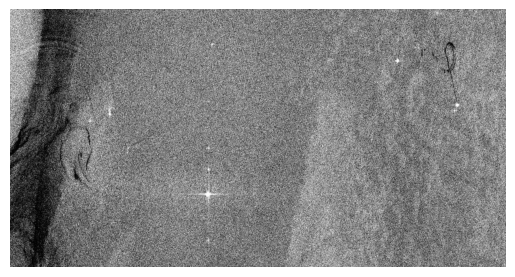

Randomly selected image: img_0006.jpg


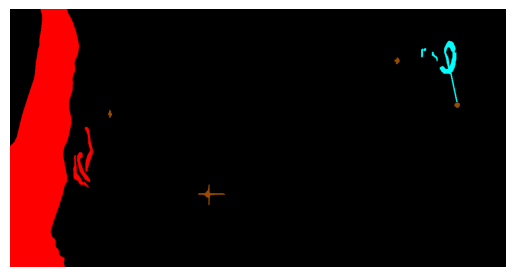

Randomly selected mask: img_0006.png


In [ ]:
# Choose a random image and mask filename from the list
random_image_name = IMG_IDS[5]
random_mask_name = LABELS_IDS[5]

# Construct the full image path
image_path = os.path.join(IMG_PATH, random_image_name)
mask_path = os.path.join(LABELS_PATH, random_mask_name)

# Read and plot the image
img = mpimg.imread(image_path)
mask = mpimg.imread(mask_path)

plt.imshow(img)
plt.axis('off')
plt.show()

print("Randomly selected image:", random_image_name)

plt.imshow(mask)
plt.axis('off')
plt.show()

print("Randomly selected mask:", random_mask_name)

In [ ]:
COLOR_MAP = [
    [0, 0, 0],
    [0, 255, 255],
    [255, 0, 0],
    [153, 76, 0],
    [0, 153, 0],
]

def process_mask(rgb_mask, colormap):
    output_mask = []

    for i, color in enumerate(colormap):
        cmap = np.all(np.equal(rgb_mask, color), axis=-1)
        output_mask.append(cmap)

    output_mask = np.stack(output_mask, axis=-1)
    return output_mask

In [ ]:
train_images = []
train_masks = []

test_images = []
test_masks = []

## train set

In [ ]:
for image_filename, mask_filename in tqdm(zip(IMG_IDS, LABELS_IDS),total = len(IMG_IDS)):
    image_path = os.path.join(IMG_PATH, image_filename)
    mask_path = os.path.join(LABELS_PATH, mask_filename)

    image = cv2.imread(image_path,cv2.IMREAD_COLOR)

    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))

    # normalizing the image
    image = image / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    processed_mask = process_mask(mask,COLOR_MAP)
    grayscale_mask = np.argmax(processed_mask, axis=-1)
    grayscale_mask = np.expand_dims(grayscale_mask, axis=-1)

    train_images.append(image)
    train_masks.append(grayscale_mask)

# Convert the lists to arrays
train_images = np.array(train_images)
train_masks = np.array(train_masks)

100%|██████████| 1002/1002 [00:26<00:00, 37.53it/s]


In [ ]:
train_masks.shape

(1002, 256, 256, 1)

In [ ]:
unique_values = np.unique(train_masks)
print("Unique values in train_masks:", unique_values)

Unique values in train_masks: [0 1 2 3 4]


## Plotting the train images

In [ ]:
import matplotlib.colors as mcolors

# Scale the color values in COLOR_MAP to the range [0, 1]
scaled_color_map = [[c[0] / 255.0, c[1] / 255.0, c[2] / 255.0] for c in COLOR_MAP]

# Define a consistent color map based on the scaled COLOR_MAP
cmap = mcolors.ListedColormap(scaled_color_map)
num_images_to_plot = 5
for i in range(num_images_to_plot):
    plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
    plt.subplot(1, 2, 1)  # Subplot for the image
    plt.imshow(train_images[i])  # Display the image
    plt.title("Image")

    plt.subplot(1, 2, 2)  # Subplot for the processed mask
    plt.imshow(train_masks[i].squeeze(), cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(COLOR_MAP)))
    plt.title("Processed Mask (Class Indices)")

    plt.show()

## test set

In [ ]:
for image_filename, mask_filename in tqdm(zip(IMG_IDS_TEST, LABELS_IDS_TEST),total = len(IMG_IDS_TEST)):
    image_path = os.path.join(IMG_PATH_TEST, image_filename)
    mask_path = os.path.join(LABELS_PATH_TEST, mask_filename)

    image = cv2.imread(image_path,cv2.IMREAD_COLOR)

    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))

    # normalizing the image
    image = image / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    processed_mask = process_mask(mask,COLOR_MAP)
    grayscale_mask = np.argmax(processed_mask, axis=-1)
    grayscale_mask = np.expand_dims(grayscale_mask, axis=-1)

    test_images.append(image)
    test_masks.append(grayscale_mask)

# Convert the lists to np arrays
test_images = np.array(test_images)
test_masks = np.array(test_masks)

100%|██████████| 110/110 [00:02<00:00, 36.79it/s]


In [ ]:
test_masks.shape

(110, 256, 256, 1)

In [ ]:
unique_values = np.unique(test_masks)
print("Unique values in test_masks:", unique_values)

Unique values in test_masks: [0 1 2 3 4]


## Using to_categorical for the masks

In [ ]:
from keras.utils import to_categorical

train_masks = to_categorical(train_masks, num_classes = 5)

In [ ]:
print(train_images.shape)
print(train_masks.shape)

(1002, 256, 256, 3)
(1002, 256, 256, 5)


In [ ]:
print(test_images.shape)
print(test_masks.shape)

(110, 256, 256, 3)
(110, 256, 256, 1)


In [ ]:
print(np.unique(train_masks))
print(np.unique(test_masks))

[0. 1.]
[0 1 2 3 4]


## train masks pixel count

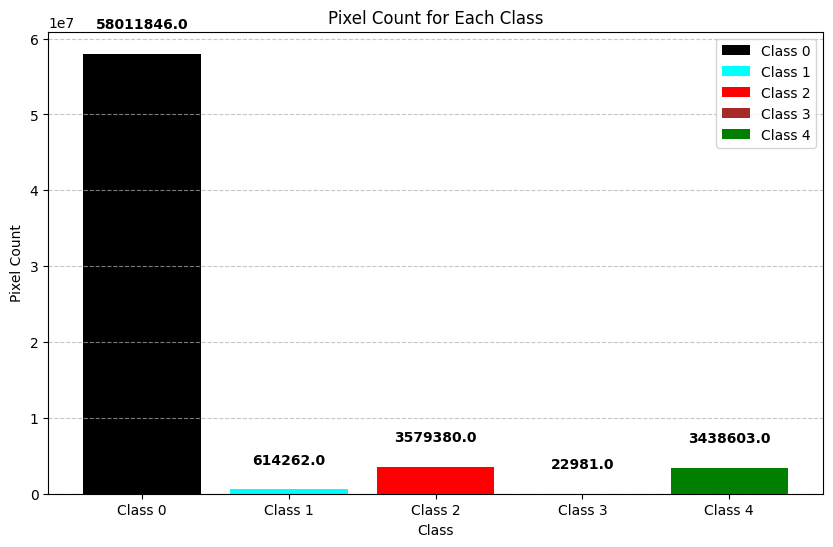

In [ ]:
num_classes = 5

# Calculate pixel counts for each class
class_pixel_counts = np.sum(train_masks, axis=(0, 1, 2))

# Class labels
class_labels = [f'Class {i}' for i in range(num_classes)]

# Define different colors for each class
colors = ['black', 'cyan', 'red', 'brown', 'green']

# Plotting the bar graph with different colors and added styling
plt.figure(figsize=(10, 6))
bars = plt.bar(class_labels, class_pixel_counts, color=colors)

# Adding labels and title
plt.xlabel('Class')
plt.ylabel('Pixel Count')
plt.title('Pixel Count for Each Class')

# Adding legend
plt.legend(bars, class_labels)

# Adding grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding value annotations on top of each bar
for bar, count in zip(bars, class_pixel_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05 * max(class_pixel_counts),
             f'{count}', ha='center', va='bottom', color='black', fontweight='bold')

plt.show()

In [ ]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

# UNet Model

In [ ]:
def UNet(input_shape, IMG_CLASSES):

    inputs = Input(input_shape)

    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

    outputs = Conv2D(IMG_CLASSES, (1,1), activation="softmax")(c9)

    model = Model(inputs, outputs)
    return model

In [ ]:
unet_model = UNet(input_shape, IMG_CLASSES)

unet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 32, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 128)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 1,941,173 (7.40 MB)

 Trainable params: 1,941,173 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
tf.keras.backend.clear_session()

unet_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

## Train the unet_model

In [ ]:
unet_history = unet_model.fit(train_images, train_masks,
                    epochs=100,
                    batch_size=16,
                    validation_split=0.1,
                    verbose=1)

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 45s 388ms/step - accuracy: 0.6827 - loss: 0.9708 - val_accuracy: 0.8967 - val_loss: 0.4655
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.8860 - loss: 0.5029 - val_accuracy: 0.8967 - val_loss: 0.4020
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.8858 - loss: 0.4486 - val_accuracy: 0.9001 - val_loss: 0.3913
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.8931 - loss: 0.3856 - val_accuracy: 0.9153 - val_loss: 0.2461
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.8842 - loss: 0.3470 - val_accuracy: 0.9074 - val_loss: 0.2467
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.8882 - loss: 0.3080 - val_accuracy: 0.9348 - val_loss: 0.2077
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.9023 - loss: 0.2820 - val_accuracy: 0.9331 - val_loss: 0.2060
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.9130 - loss: 0.2567 - val_accuracy: 

## model visualisation

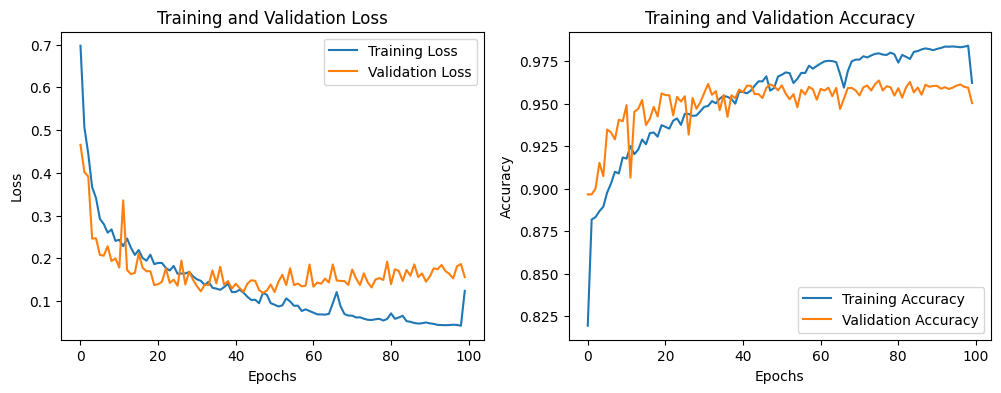

In [ ]:
# Access the training history
unet_loss = unet_history.history['loss']
unet_val_loss = unet_history.history['val_loss']
unet_accuracy = unet_history.history['accuracy']
unet_val_accuracy = unet_history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(unet_loss, label='Training Loss')
plt.plot(unet_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(unet_accuracy, label='Training Accuracy')
plt.plot(unet_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## prediciton visualization

In [ ]:
# Generate a random index within the range of test_images
test_image_number = random.randint(0, len(test_images) - 1)

num_images_to_plot = 10
for i in range(num_images_to_plot):
    plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

    # Test Image
    plt.subplot(1, 3, 1)  # Subplot for the image
    test_image = test_images[i]
    plt.imshow(test_image)  # Display the image
    plt.title("Image")

    # Test Mask
    plt.subplot(1, 3, 2)  # Subplot for the test mask
    test_mask = test_masks[i]
    plt.imshow(test_mask.squeeze(), cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(COLOR_MAP)))
    plt.title("Test Mask")

    # Predicted Mask
    plt.subplot(1, 3, 3)  # Subplot for the predicted mask
    prediction_unet = unet_model.predict(np.expand_dims(test_image, axis=0))
    predicted_mask_unet = np.argmax(prediction_unet, axis=3)[0, :, :]
    plt.imshow(predicted_mask_unet.squeeze(), cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(COLOR_MAP)))
    plt.title("Predicted Mask")

    plt.show()


## Confusion matrix for Unet model

In [ ]:
prediction_unet = unet_model.predict(test_images)

print(test_masks.shape)
print(prediction_unet.shape)

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 893ms/step
(110, 256, 256, 1)
(110, 256, 256, 5)


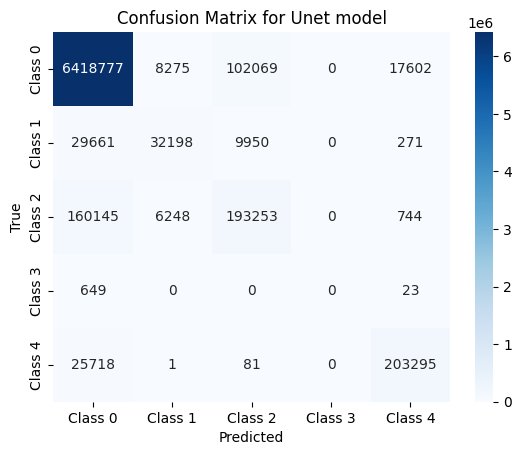

In [ ]:
# Flatten the arrays to 1D
unet_true_labels = test_masks.flatten()
unet_predicted_labels = np.argmax(prediction_unet, axis=-1).flatten()

# Create the confusion matrix
cm = confusion_matrix(unet_true_labels, unet_predicted_labels)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Unet model')
plt.show()

In [ ]:
# Calculate precision, recall, and F1 score
precision = precision_score(unet_true_labels, unet_predicted_labels, average='weighted')
recall = recall_score(unet_true_labels, unet_predicted_labels, average='weighted')
f1 = f1_score(unet_true_labels, unet_predicted_labels, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.9462
Recall: 0.9499
F1 Score: 0.9475


# DeepLapV3 Model

In [ ]:
# atrous_spatial_pyramid_pooling
def ASPP(inputs):
    shape = inputs.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation('relu')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation('relu')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation('relu')(y_18)

    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y

In [ ]:
def DeepLabV3Plus(input_shape, IMG_CLASSES):
    # Inputs
    inputs = layers.Input(input_shape)

    # Pre-trained ResNet50
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    # Pre-trained ResNet50 Output
    image_features = base_model.get_layer('conv4_block6_out').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    # Get low-level features
    x_b = base_model.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)

    # Outputs
    x = Conv2D(IMG_CLASSES, (1, 1), name='output_layer')(x)
    x = Activation('softmax')(x)

    # Model
    model = Model(inputs=inputs, outputs=x)
    return model

In [ ]:
deeplab_model = DeepLabV3Plus(input_shape, IMG_CLASSES)
deeplab_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 17,831,237 (68.02 MB)

 Trainable params: 17,796,453 (67.89 MB)

 Non-trainable params: 34,784 (135.88 KB)

In [ ]:
import tensorflow.keras.backend as K  # Ensure correct import

def jaccard_coef(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)  # Use tf.keras.backend.flatten()
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)

    return final_coef_value

In [ ]:
# treating all classes equally in terms of their contribution to the loss.
class_weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

In [ ]:
!pip install -U -q segmentation-models
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

dice_loss = sm.losses.DiceLoss(class_weights = class_weights)
focal_loss = sm.losses.CategoricalFocalLoss()

total_loss = dice_loss + focal_loss

In [ ]:
tf.keras.backend.clear_session()

# # Define the learning rate
# learning_rate = 10e-5

# # Create an instance of the Adam optimizer with the specified learning rate
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

deeplab_model.compile(optimizer='adam', loss=total_loss, metrics = ["accuracy", jaccard_coef])

In [ ]:
deeplab_history = deeplab_model.fit(train_images, train_masks,
                                    epochs=50,
                                    batch_size=16,
                                    validation_split=0.05,  # Reduce if dataset is small
                                    verbose=1)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.7964 - jaccard_coef: 0.5912 - loss: 0.9678 - val_accuracy: 0.8276 - val_jaccard_coef: 0.7284 - val_loss: 1.1043
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 253ms/step - accuracy: 0.9218 - jaccard_coef: 0.8099 - loss: 0.9250 - val_accuracy: 0.0814 - val_jaccard_coef: 0.0394 - val_loss: 1.7303
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 253ms/step - accuracy: 0.9298 - jaccard_coef: 0.8344 - loss: 0.9175 - val_accuracy: 0.8762 - val_jaccard_coef: 0.4015 - val_loss: 0.9836
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 251ms/step - accuracy: 0.9335 - jaccard_coef: 0.8542 - loss: 0.9107 - val_accuracy: 0.9163 - val_jaccard_coef: 0.8496 - val_loss: 0.9939
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 250ms/step - accuracy: 0.9390 - jaccard_coef: 0.8659 - loss: 0.9017 - val_accuracy: 0.9163 - val_jaccard_coef: 0.8764 - val_loss: 1.0193
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 249ms/step - accuracy: 0.9371 - jaccard_coef: 0.8650 - loss: 0.89

## model visualization

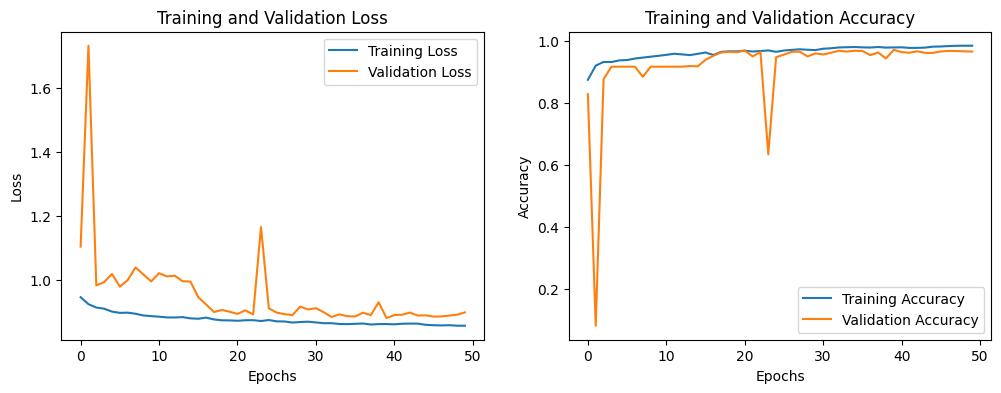

In [ ]:
# Access the training history
deeplab_loss = deeplab_history.history['loss']
deeplab_val_loss = deeplab_history.history['val_loss']
deeplab_accuracy = deeplab_history.history['accuracy']
deeplab_val_accuracy = deeplab_history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(deeplab_loss, label='Training Loss')
plt.plot(deeplab_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(deeplab_accuracy, label='Training Accuracy')
plt.plot(deeplab_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## prediciton visualization

In [ ]:
# Generate a random index within the range of test_images
test_image_number = random.randint(0, len(test_images) - 1)

num_images_to_plot = 10
for i in range(num_images_to_plot):
    plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

    # Test Image
    plt.subplot(1, 3, 1)  # Subplot for the image
    test_image = test_images[i]
    plt.imshow(test_image)  # Display the image
    plt.title("Image")

    # Test Mask
    plt.subplot(1, 3, 2)  # Subplot for the test mask
    test_mask = test_masks[i]
    plt.imshow(test_mask.squeeze(), cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(COLOR_MAP)))
    plt.title("Test Mask")

    # Predicted Mask
    plt.subplot(1, 3, 3)  # Subplot for the predicted mask
    prediction_deeplab = deeplab_model.predict(np.expand_dims(test_image, axis=0))
    predicted_mask_deeplab = np.argmax(prediction_deeplab, axis=3)[0, :, :]
    plt.imshow(predicted_mask_deeplab.squeeze(), cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(COLOR_MAP)))
    plt.title("Predicted Mask")

    plt.show()


## Confusion matrix for deeplabV3 model

In [ ]:
prediction_deeplab = deeplab_model.predict(test_images)

print(test_masks.shape)
print(prediction_deeplab.shape)

4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step
(110, 256, 256, 1)
(110, 256, 256, 5)


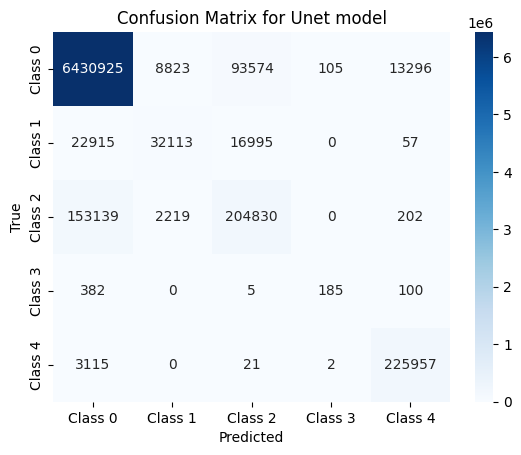

In [ ]:
# Flatten the arrays to 1D
deeplab_true_labels = test_masks.flatten()
deeplab_predicted_labels = np.argmax(prediction_deeplab, axis=-1).flatten()

# Create the confusion matrix
cm = confusion_matrix(deeplab_true_labels, deeplab_predicted_labels)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Unet model')
plt.show()


In [ ]:
# Calculate precision, recall, and F1 score
precision = precision_score(deeplab_true_labels, deeplab_predicted_labels, average='weighted')
recall = recall_score(deeplab_true_labels, deeplab_predicted_labels, average='weighted')
f1 = f1_score(deeplab_true_labels, deeplab_predicted_labels, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9534
Recall: 0.9563
F1 Score: 0.9543


# PSPNet model

In [ ]:
from keras.layers import Lambda

# PSPNet Architecture
def PSPNet(input_shape, IMG_CLASSES):
    inputs = Input(input_shape)

    resnet = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)

    pyramid_layers = []

    for pool_size in [1, 2, 3, 6]:
        pyramid = AveragePooling2D(pool_size=(pool_size, pool_size))(resnet.output)
        pyramid = Conv2D(128, (1, 1), activation='relu')(pyramid)
        pyramid = Lambda(lambda x: tf.image.resize(x, (IMG_HEIGHT, IMG_WIDTH), method='bilinear'))(pyramid)
        pyramid_layers.append(pyramid)

    merged = Concatenate(axis=-1)(pyramid_layers)
    merged = BatchNormalization()(merged)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(merged)
    x = Dropout(0.5)(x)
    x = Conv2D(IMG_CLASSES, (1, 1), activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

In [ ]:
pspnet_model = PSPNet(input_shape, IMG_CLASSES)
pspnet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 27,001,221 (103.00 MB)

 Trainable params: 26,947,077 (102.79 MB)

 Non-trainable params: 54,144 (211.50 KB)

In [ ]:
import tensorflow as tf

tf.keras.backend.clear_session()

# Define the learning rate
learning_rate = 10e-5

# Define loss function (example: categorical crossentropy or a custom loss function)
total_loss = tf.keras.losses.CategoricalCrossentropy()

# Define the Jaccard coefficient (IoU) function
def jaccard_coef(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + tf.keras.backend.epsilon())

# Create an instance of the Adam optimizer with the specified learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

pspnet_model.compile(optimizer=optimizer, loss=total_loss, metrics=["accuracy", jaccard_coef])

In [ ]:
history = pspnet_model.fit(
    train_images,
    train_masks,
    epochs=50,
    batch_size=8,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.7065 - jaccard_coef: 0.5312 - loss: 0.9578 - val_accuracy: 0.8911 - val_jaccard_coef: 0.6723 - val_loss: 0.5619
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 56s 499ms/step - accuracy: 0.9196 - jaccard_coef: 0.8013 - loss: 0.2551 - val_accuracy: 0.0478 - val_jaccard_coef: 0.0433 - val_loss: 3.4749
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 56s 494ms/step - accuracy: 0.9264 - jaccard_coef: 0.8149 - loss: 0.2164 - val_accuracy: 0.0478 - val_jaccard_coef: 0.0514 - val_loss: 2.9834
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 56s 496ms/step - accuracy: 0.9437 - jaccard_coef: 0.8519 - loss: 0.1639 - val_accuracy: 0.0506 - val_jaccard_coef: 0.0384 - val_loss: 4.2145
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 56s 495ms/step - accuracy: 0.9510 - jaccard_coef: 0.8660 - loss: 0.1360 - val_accuracy: 0.1570 - val_jaccard_coef: 0.1276 - val_loss: 2.2049
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 56s 495ms/step - accuracy: 0.9553 - jaccard_coef: 0.8769 

## model visualization

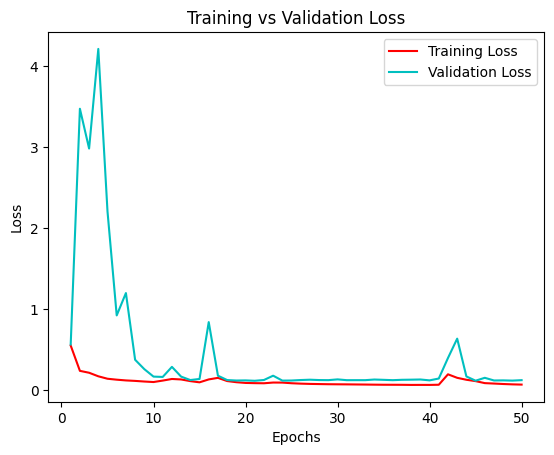

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'c', label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
y_pred_pspnet = pspnet_model.predict(test_images)
y_pred_pspnet_argmax = np.argmax(y_pred_pspnet, axis=-1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 58s 8s/step


In [ ]:
y_test = to_categorical(test_masks, num_classes = 5)
y_test_argmax = np.argmax(y_test, axis=3)

## model evaluation

In [ ]:
results = pspnet_model.evaluate(test_images, y_test)
print("Evaluation results:", results)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step - accuracy: 0.9603 - jaccard_coef: 0.9074 - loss: 0.1374
Evaluation results: [0.1466209888458252, 0.9559707641601562, 0.8992691040039062]


## prediction visualisation

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


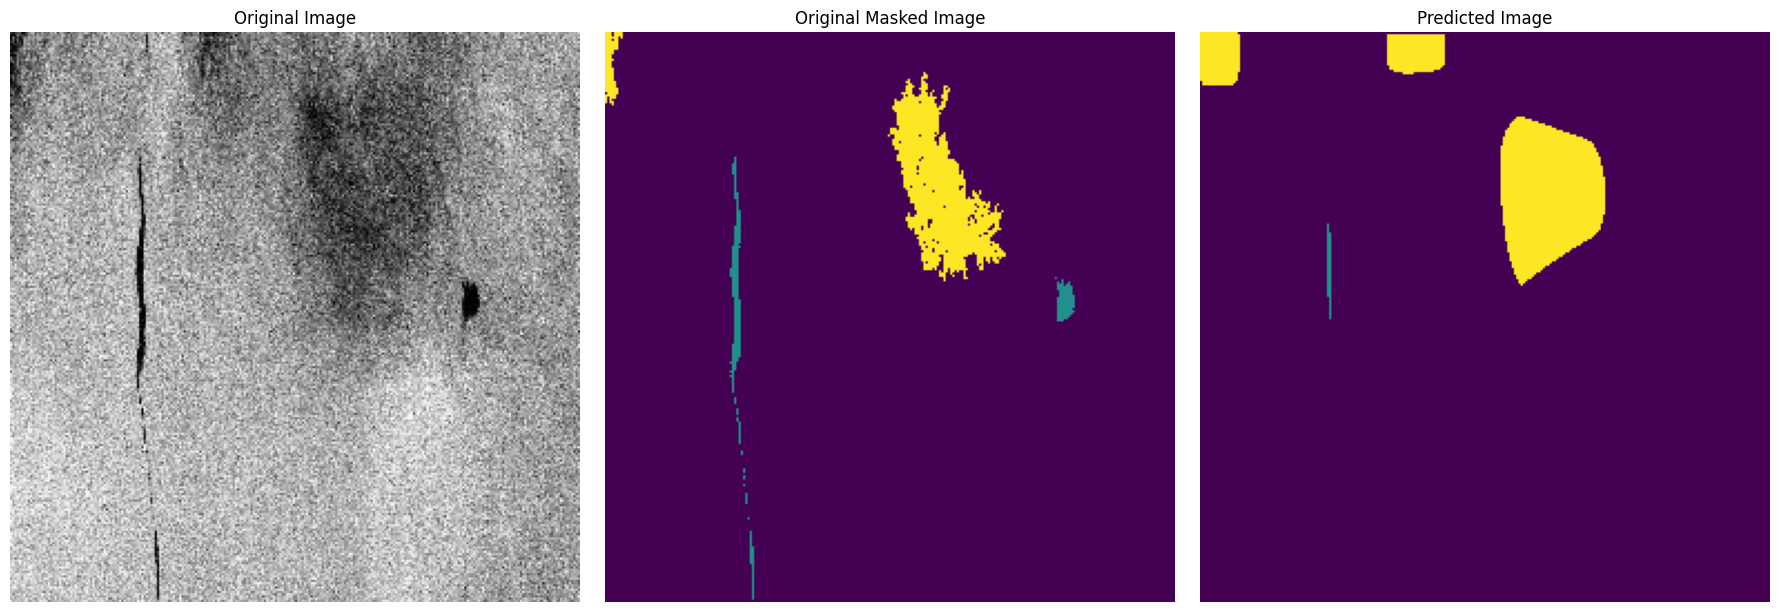

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Generate a random index within the range of test_images
test_image_number = random.randint(0, len(test_images) - 1)

# Retrieve the test image and its corresponding ground truth
test_image = test_images[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

# Expand dimensions of the test image to match the model input shape
test_image_input = np.expand_dims(test_image, axis=0)

# Get the model's prediction for the test image
prediction = pspnet_model.predict(test_image_input)

# Find the index of the highest predicted value along the channel axis
predicted_image = np.argmax(prediction, axis=3)[0, :, :]

# Create a figure and a grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the original image
axes[0].imshow(test_image)
axes[0].set_title("Original Image")
axes[0].axis('off')  # Turn off axis labels

# Plot the original masked image
axes[1].imshow(ground_truth_image)
axes[1].set_title("Original Masked Image")
axes[1].axis('off')  # Turn off axis labels

# Plot the predicted image
axes[2].imshow(predicted_image)
axes[2].set_title("Predicted Image")
axes[2].axis('off')  # Turn off axis labels

# Adjust layout and spacing
plt.tight_layout()

# Display the plot
plt.show()
